
# Required Imports


In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import glob
import nltk

import itertools
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import chart_studio.plotly as py
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

import gensim.models.word2vec as w2v
from sklearn.manifold import TSNE
import plotly.express as px

from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
from fastcluster import linkage
from matplotlib.colors import rgb2hex, colorConverter

/Users/rishabhsrivastava/mypython/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/rishabhsrivastava/mypython/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/rishabhsrivastava/mypython/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/rishabhsrivastava/mypython/lib/python3.8/s


# Reading all csv's and creating a dataframe(for english language)


In [2]:
all_files=glob.glob("/Users/rishabhsrivastava/Downloads/CSVS/DIKSHA APP REVIEWS AND RATINGS/"+"/*.csv")
dflist = []


In [3]:
for filename in all_files:
    # Dataframe of one file
    df_sm = pd.read_csv(filename, index_col=None, header=0)
    dflist.append(df_sm)
    
df = pd.concat(dflist, axis=0, ignore_index=True)


In [4]:
df.dropna(subset=["Review Text"],inplace=True)


In [5]:
eng_data = df.loc[df['Reviewer Language']=='en']
eng_df = pd.DataFrame(eng_data)


In [6]:
eng_df.reset_index(inplace = True) 


In [7]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
import re

def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
       # The yield statement suspends function’s execution and sends a value back to the caller.
        yield subtree.leaves()

def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
                    and word.lower() not in stopwords)
    return accepted

def get_terms(tree):

    for leaf in leaves(tree):
        term = [ w for w,t in leaf if acceptable_word(w) ]
        yield term


In [8]:
grammar =r"""
  NP: {<DT|JJ|NN.*>+}          
  PP: {<IN><NP>}            
  VP: {<VB.*><NP|PP|CLAUSE>+$}
  CLAUSE: {<NP><VP>}          
  """
      
    

In [9]:
def phrase_extraction(text, grammar):
    text = text.lower()
    sentence_re = r'''(?x)          
      (?:[A-Z]\.)+        
    | \w+(?:-\w+)*        
    | \$?\d+(?:\.\d+)?%?  
    | \.\.\.              
    | [][.,;"'?():_`-]    
    '''
    
    ls = [] 
    word_token_ls = text.split(" ")

    toks = nltk.regexp_tokenize(text, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    
    chunker = nltk.RegexpParser(grammar)
    
    tree = chunker.parse(postoks)
    terms = get_terms(tree)
    for term in terms:
        ls.append(" ".join(term)) 
    return list(set(ls))




# Preprocessing of Review Text


In [10]:
ls = list(eng_df["Review Text"])


In [11]:
dic = dict(zip(eng_df["Review Text"],eng_df["Star Rating"]))


In [12]:
# changing review text into lowecase

review_text_lower = {}
for i ,j in dic.items():
    review_text_lower[i.lower()] = j
    


In [13]:
# changing review text into lowecase

# out = map(lambda x:x.lower(), dic)  
# review_text_lower = dict(out)
# review_text_lower

In [14]:
# Numbers removing
import re
review_text_lower_wdoutno = {}
for i ,j in review_text_lower.items():
    review_text_lower_wdoutno[re.sub(r'\d+', '', i)] = j
    


In [15]:
# Numbers removing

# import re
# review_text_lower_wdoutno = list(map(lambda x: re.sub(r'\d+', '', x), review_text_lower)) 
# review_text_lower_wdoutno




In [16]:
# Remove punctuation
import string 

def remove_punctuation(text): 
    translator = str.maketrans('', '', string.punctuation) 
    return text.translate(translator) 

review_text_wdout_punct = {}
for i,j in review_text_lower.items():
    review_text_wdout_punct[remove_punctuation(i)] = j
 

In [17]:
# remove whitespace from text 
def remove_whitespace(text): 
    return " ".join(text.split()) 

review_text_wdout_whitespace = {}
for i,j in review_text_wdout_punct.items():
    review_text_wdout_whitespace[remove_whitespace(i)] = j
  


In [18]:
# convert a list to string    
def listToString(s):  
    str1 = ""   
    for ele in s:  
        str1 += ele   
        str1 += ' '
    return str1  
        

In [19]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  
# remove stopwords function 
def remove_stopwords(text): 
    stop_words = list(stopwords.words("english")) 
    word_tokens = word_tokenize(text) 
    filtered_text = [word for word in word_tokens if word not in stop_words] 
    return filtered_text 
  
review_text_wdout_stopwords = {}
for i,j in review_text_wdout_whitespace.items():
    x = remove_stopwords(i)
    y = listToString(x)
    review_text_wdout_stopwords[y] = j


In [20]:
# remove emoji
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

review_text_wdout_emojis = {}
for i,j in review_text_wdout_stopwords.items():
    x = deEmojify(i)
    review_text_wdout_emojis[x] = j


In [21]:
# lemmatization
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
lemmatizer = WordNetLemmatizer() 

# lemmatize string 
def lemmatize_word(text): 
    word_tokens = word_tokenize(text) 
    # provide context i.e. part-of-speech 
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
    return lemmas 
  
review_text_lemmas = {}
for i,j in review_text_wdout_emojis.items():
    x = lemmatize_word(i)
    y = listToString(x)
    review_text_lemmas[y] = j


In [22]:
#stemming

# from nltk.stem.porter import PorterStemmer 
# from nltk.tokenize import word_tokenize 
# stemmer = PorterStemmer() 

# # stem words in the list of tokenised words 
# def stem_words(text): 
#     word_tokens = word_tokenize(text) 
#     stems = [stemmer.stem(word) for word in word_tokens] 
#     return stems 

 


In [23]:
# remove review text containing less than 3 words using regex (findall()) 

import re 

processed_review_text = {}
for i,j in review_text_lemmas.items():
    res = len(re.findall(r'\w+', i)) 
    if(res>=3):
        processed_review_text[i] = j
        
    


# Dataframe of filtered Review Text and their corresponding star rating 


In [24]:
# df2 = pd.DataFrame(processed_review_text.values())
# df2

initial_df = pd.DataFrame(list(zip(processed_review_text.keys(), processed_review_text.values())), 
               columns =['Review Text', 'Star Rating']) 


In [25]:
final_processed_review_text = []
for key in processed_review_text.keys():
    final_processed_review_text.append(key)



# Vectorization of Review Text(Word Embeddings) 512-D


In [26]:
# Vectorization

def vectorization_of_list(input_list):
    #word embedding(vectorization)
    embed = hub.Module("/Users/rishabhsrivastava/Downloads/vectorization_trained_dataset/")
    tf.logging.set_verbosity(tf.logging.ERROR)
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        message_embeddings = session.run(embed(input_list))
#         print(message_embeddings)
        lst = []
        for i in message_embeddings:
            df = pd.DataFrame([i])
            lst.append(df)
    frame = pd.concat(lst)
    return frame


In [27]:
vectorized_frame = vectorization_of_list(final_processed_review_text)
  

In [28]:
# from sklearn.metrics.pairwise import cosine_similarity
# cosine_similarity([vectorized_frame[0]], [vectorized_frame[1]])

In [29]:
review_text_df = pd.DataFrame(final_processed_review_text,columns=['Review Text'])


In [30]:
vectorized_frame.set_index(review_text_df["Review Text"], inplace = True) 


In [31]:
vectorized_frame.to_csv ('/Users/rishabhsrivastava/Downloads/CSVS/Vectorized_processed_review_text.csv', index = False, header=True)



# Dimension Reduction from 512D to 3D and 2D (T-SNE)


In [32]:
def TSNE_3D(df):
    %pylab inline 

    #Reduce Dimensinality
    X_embedded = TSNE(n_components=3).fit_transform(df)
    vec_df = pd.DataFrame(X_embedded, columns=["ft1","ft2","ft3"])
    #vec_df
    #plot 3-D graph
    fig = px.scatter_3d(vec_df,x="ft1",y="ft2",z="ft3")
    fig.show()

In [33]:
TSNE_3D(vectorized_frame)

Populating the interactive namespace from numpy and matplotlib


In [34]:
def TSNE_2D(df):
    %pylab inline 

    #Reduce Dimensinality
    X_embedded = TSNE(n_components=2).fit_transform(df)
    vec_df = pd.DataFrame(X_embedded, columns=["ft1","ft2"])
    #vec_df
    #plot 3-D graph
    fig = px.scatter(vec_df,x="ft1",y="ft2")
    fig.show()

In [35]:
TSNE_2D(vectorized_frame)

Populating the interactive namespace from numpy and matplotlib



# Dendrograms and hierarchial clustering of Review Text vectors - scatter plot


In [36]:
def dendrogram_genetator(df):
    plt.figure(figsize=(10, 7))  
    plt.title("Dendrograms")  
    dend = shc.dendrogram(shc.linkage(df, method='ward'))
    

In [37]:
%pylab inline
#Reduce Dimensinality
X_embedded = TSNE(n_components=2).fit_transform(vectorized_frame)
vec_df = pd.DataFrame(X_embedded, columns=["ft1","ft2"])
vec_df

Populating the interactive namespace from numpy and matplotlib


ft1        ft2
0    -41.548264   8.765465
1    -45.897083  -1.152765
2     17.882038  34.803932
3    -53.795380  -5.987590
4     18.692850  45.798088
...         ...        ...
4048   4.685256  51.366535
4049  34.645439  12.472134
4050 -28.216562  24.322689
4051  55.907452 -27.494328
4052 -32.843174 -19.691633

[4053 rows x 2 columns]

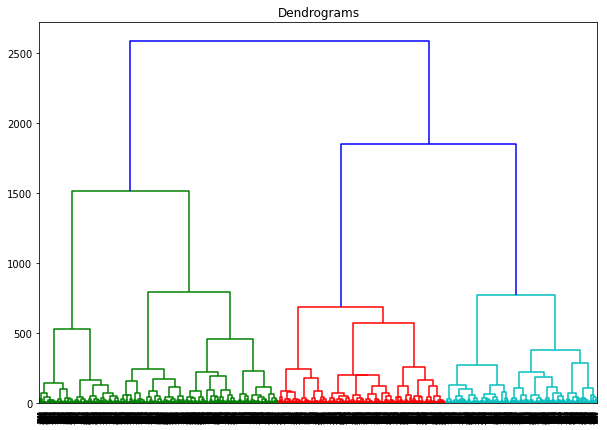

In [38]:
dendrogram_genetator(vec_df)

In [39]:
def dendrogram_genetator_with_thresold(df,thresold):
    plt.figure(figsize=(10, 7))
#     y=800
    plt.title("Dendrograms")  
    dend = shc.dendrogram(shc.linkage(df, method='ward'))
    plt.axhline(thresold, color='r', linestyle='--')
    


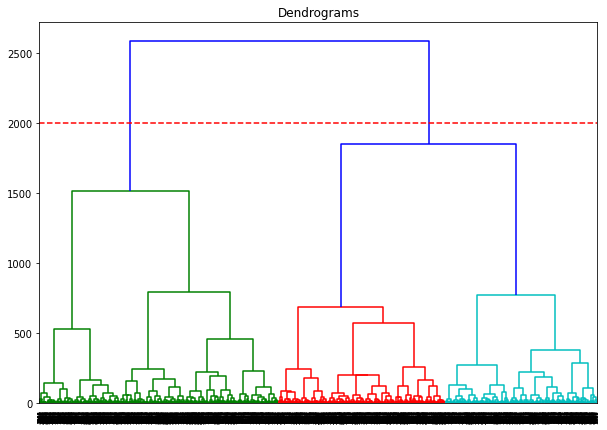

In [40]:
dendrogram_genetator_with_thresold(vec_df,2000)

In [41]:
def hierarchial_clustering(df):
    cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
    cluster.fit_predict(df)
    
    plt.figure(figsize=(10, 7))  
    plt.scatter(df['ft1'], df['ft2'], c=cluster.labels_) 
    

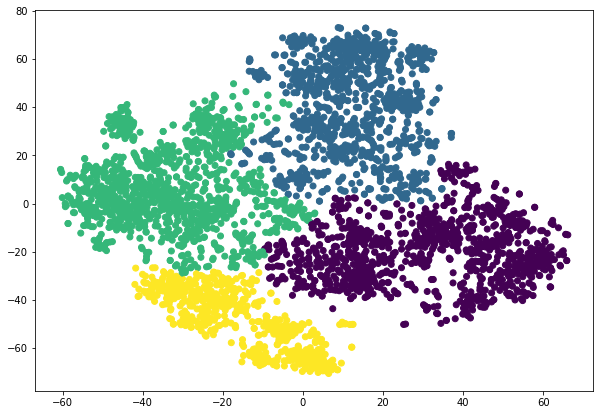

In [42]:
hierarchial_clustering(vec_df)

In [43]:
#result.reset_index(drop=True, inplace=True)
vec_df.set_index(review_text_df["Review Text"], inplace = True) 


ft1        ft2
Review Text                                                             
best app 4 students                                -41.548264   8.765465
app usefull students teachers                      -45.897083  -1.152765
work mobile even android 73                         17.882038  34.803932
good app secondary school teacher notice dixa s... -53.795380  -5.987590
good app lean                                       18.692850  45.798088
...                                                       ...        ...
app good app                                         4.685256  51.366535
please complete content early                       34.645439  12.472134
good best learn app                                -28.216562  24.322689
super excellent extraordinariy                      55.907452 -27.494328
instal app bar code hsc text bookeven commencem... -32.843174 -19.691633

[4053 rows x 2 columns]


# Element extraction from clusters


In [44]:
def cluster_element_extraction(vec_df):
    sns.set_palette('Set1', 10, 0.65)
    palette = (sns.color_palette())
    #set_link_color_palette(map(rgb2hex, palette))
    sns.set_style('white')
    
    np.random.seed(25)
    
    link = linkage(vec_df, metric='correlation', method='ward')

    figsize(8, 3)
    den = dendrogram(link, labels=vec_df.index)
    plt.xticks(rotation=90)
    no_spine = {'left': True, 'bottom': True, 'right': True, 'top': True}
    sns.despine(**no_spine);

    plt.tight_layout()
    plt.savefig('feb2.png');
    
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
                
    class Clusters(dict):
        def _repr_html_(self):
            html = '<table style="border: 0;">'
            for c in self:
                hx = rgb2hex(colorConverter.to_rgb(c))
                html += '<tr style="border: 0;">' \
                '<td style="background-color: {0}; ' \
                           'border: 0;">' \
                '<code style="background-color: {0};">'.format(hx)
                html += c + '</code></td>'
                html += '<td style="border: 0"><code>' 
                html += repr(self[c]) + '</code>'
                html += '</td></tr>'

            html += '</table>'

            return html
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den['ivl'][i] for i in l]
        cluster_classes[c] = i_l
        
    return cluster_classes
    

In [121]:
#cluster_element_extraction(vec_df)


# Element extraction from clusters for each rating


In [46]:
def clustering_rating_wise(key_rate_df, rating):
    key_data = key_rate_df.loc[key_rate_df['Star Rating'] == rating]
    key_rate_df1 = pd.DataFrame(key_data)
#     return key_rate_df1
    ky_ls =key_rate_df1['Review Text'].tolist()
    
    frame = vectorization_of_list(ky_ls)
    frame.set_index(key_rate_df1["Review Text"], inplace = True) 
    return cluster_element_extraction(frame)

In [47]:
def keyword_freq_per_cluster(cluster_elem, cluster_no):
    #changing to lower order
    out = map(lambda x:x.lower(), cluster_elem)  
    elem_lower = list(out)  
    #print(output) 
    #Creating a new Dtaframe which is required for final csv
    df_rate_c = pd.DataFrame(columns=['Review Text', 'Keywords', 'Cluster'])

    for i in elem_lower:
        if(i == ''):
            df_rate_c = df_rate_c.append({'Review Text': i, 'Keywords': '[]', 'Cluster': cluster_no}, ignore_index=True)
        else:
            x = phrase_extraction(i, grammar)
            df_rate_c = df_rate_c.append({'Review Text': i, 'Keywords': x, 'Cluster': cluster_no}, ignore_index=True)
    
    ky_ls = (df_rate_c['Keywords'].tolist())
    ky_ls_df = pd.DataFrame(ky_ls)
    return ky_ls_df[0].value_counts()[:30]


# cluster analysis for rating 5 - elements of cluster, wordcloud, frequency of most frequent words that are appearing


<ipython-input-44-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



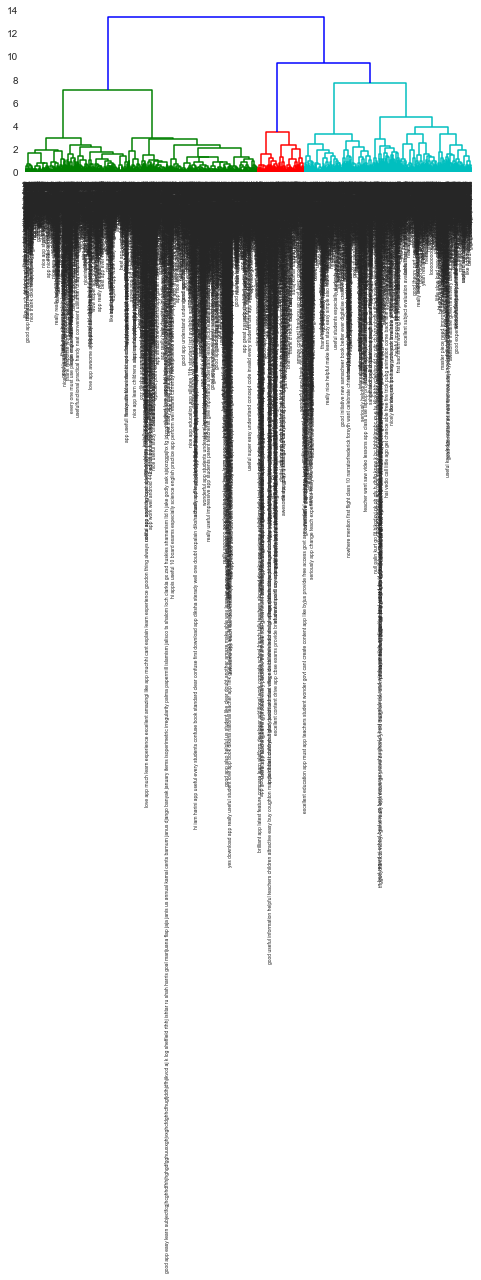

In [48]:
elem_rate5 = clustering_rating_wise(initial_df, 5)

In [49]:
g5_elem = elem_rate5['g']


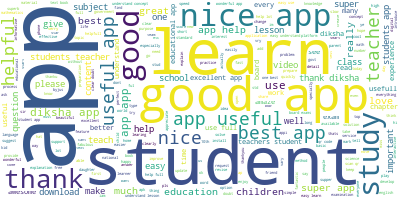

In [50]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(g5_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [51]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
import re

def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
       # The yield statement suspends function’s execution and sends a value back to the caller.
        yield subtree.leaves()

def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
                    and word.lower() not in stopwords)
    return accepted

def get_terms(tree):

    for leaf in leaves(tree):
        term = [ w for w,t in leaf if acceptable_word(w) ]
        yield term


In [123]:
#keyword_freq_per_cluster(g5_elem,1).to_dict()

In [53]:
import re
g5_most_frequent = [y for y in g5_elem if re.search('good app', y)]


In [54]:
r5_elem = elem_rate5['r']


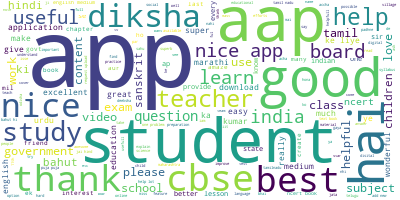

In [55]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(r5_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [124]:
#keyword_freq_per_cluster(r5_elem,2).to_dict()

In [57]:
import re
r5_most_frequent = [y for y in r5_elem if re.search('india', y)]


In [58]:
c5_elem = elem_rate5['c']


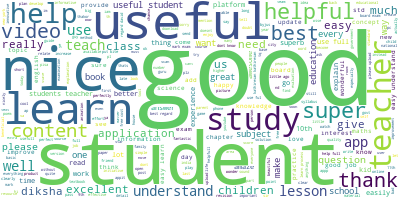

In [59]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(c5_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [125]:
#keyword_freq_per_cluster(c5_elem,3).to_dict()

In [61]:
import re
c5_most_frequent = [y for y in c5_elem if re.search('good students', y)]



# cluster analysis for rating 4 - elements of cluster, wordcloud, frequency of most frequent words that are appearing


<ipython-input-44-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



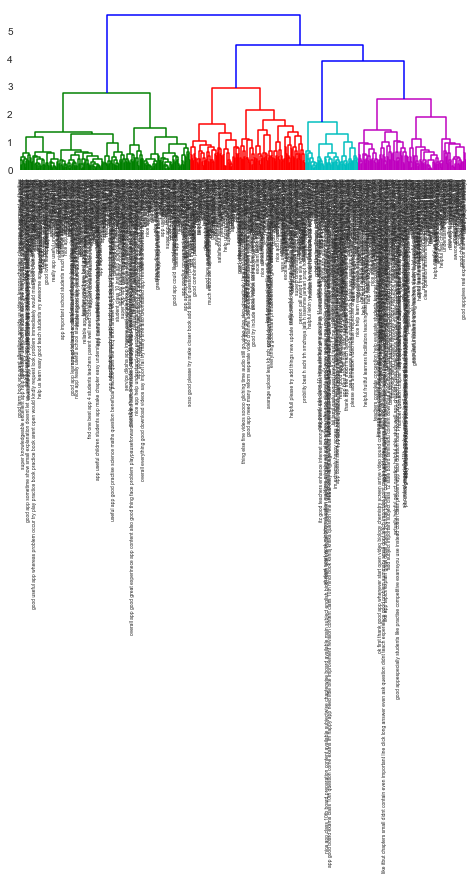

In [62]:
elem_rate4 = clustering_rating_wise(initial_df, 4)

In [63]:
g4_elem = elem_rate4['g']


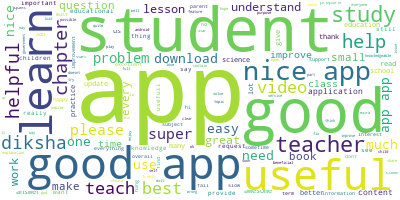

In [64]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(g4_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [126]:
#keyword_freq_per_cluster(g4_elem,1).to_dict()

In [66]:
import re
g4_most_frequent = [y for y in g4_elem if re.search('good app', y)]


In [67]:
r4_elem = elem_rate4['r']


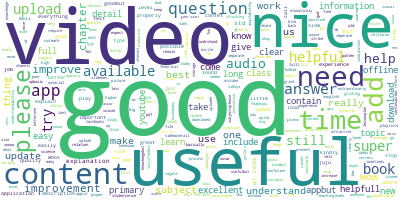

In [68]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(r4_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [127]:
#keyword_freq_per_cluster(r4_elem,2).to_dict()

In [70]:
import re
r4_most_frequent = [y for y in r4_elem if re.search('goodbut question answer available', y)]


In [71]:
c4_elem = elem_rate4['c']


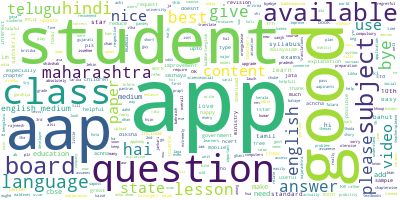

In [72]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(c4_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [128]:
#keyword_freq_per_cluster(c4_elem,3).to_dict()

In [74]:
import re
c4_most_frequent = [y for y in c4_elem if re.search('teachers', y)]



# cluster analysis for rating 3 - elements of cluster, wordcloud, frequency of most frequent words that are appearing


<ipython-input-44-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



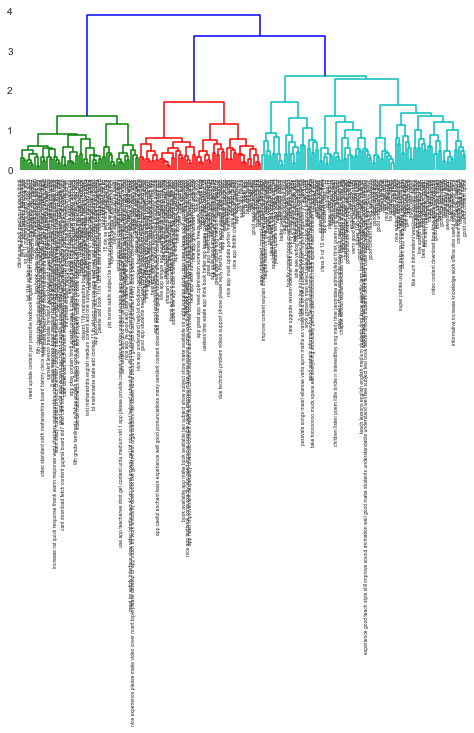

In [75]:
elem_rate3 = clustering_rating_wise(initial_df, 3)

In [76]:
g3_elem = elem_rate3['g']


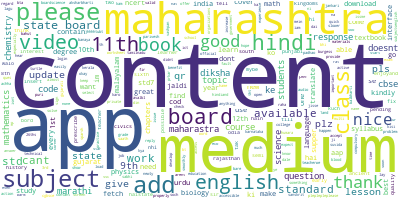

In [77]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(g3_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [129]:
#keyword_freq_per_cluster(g3_elem,1).to_dict()

In [79]:
import re
g3_most_frequent = [y for y in g3_elem if re.search('add class st state board maharashtra', y)]


In [80]:
r3_elem = elem_rate3['r']


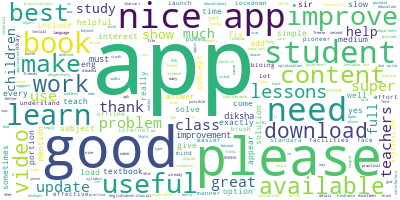

In [81]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(r3_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [130]:
#keyword_freq_per_cluster(r3_elem,2).to_dict()

In [83]:
import re
r3_most_frequent = [y for y in r3_elem if re.search('easy learn', y)]


In [122]:
c3_elem = elem_rate3['c']


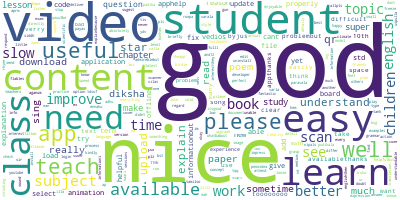

In [85]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(c3_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [131]:
#keyword_freq_per_cluster(c3_elem,3).to_dict()

In [87]:
import re
c3_most_frequent = [y for y in c3_elem if re.search('nice', y)]



# cluster analysis for rating 2 - elements of cluster, wordcloud, frequency of most frequent words that are appearing


<ipython-input-44-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



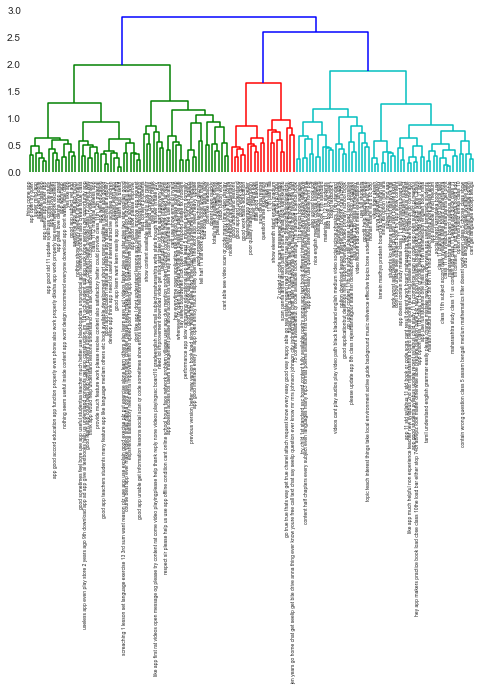

In [88]:
elem_rate2 = clustering_rating_wise(initial_df, 2)

In [89]:
g2_elem = elem_rate2['g']


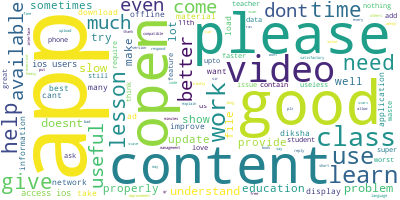

In [90]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(g2_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [132]:
#keyword_freq_per_cluster(g2_elem,1).to_dict()

In [92]:
import re
g2_most_frequent = [y for y in g2_elem if re.search('minutes', y)]


In [93]:
r2_elem = elem_rate2['r']


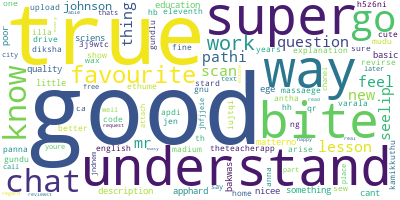

In [94]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(r2_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [133]:
#keyword_freq_per_cluster(r2_elem,2).to_dict()

In [96]:
import re
r2_most_frequent = [y for y in r2_elem if re.search('tamil', y)]


In [97]:
c2_elem = elem_rate2['c']


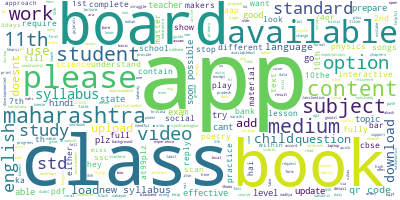

In [98]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(c2_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [134]:
#keyword_freq_per_cluster(c3_elem,3).to_dict()

In [100]:
import re
c2_most_frequent = [y for y in c4_elem if re.search('app', y)]



# cluster analysis for rating 1 - elements of cluster, wordcloud, frequency of most frequent words that are appearing


<ipython-input-44-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



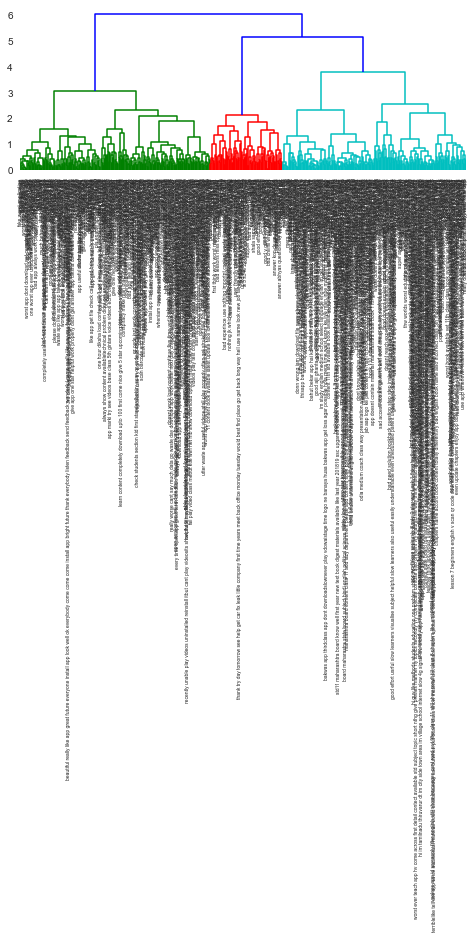

In [101]:
elem_rate1 = clustering_rating_wise(initial_df, 1)

In [102]:
g1_elem = elem_rate1['g']


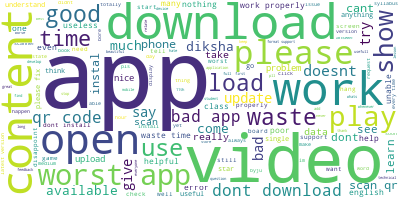

In [103]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(g1_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [135]:
#keyword_freq_per_cluster(g1_elem,1).to_dict()

In [105]:
import re
g1_most_frequent = [y for y in g1_elem if re.search('board', y)]


In [106]:
r1_elem = elem_rate1['r']


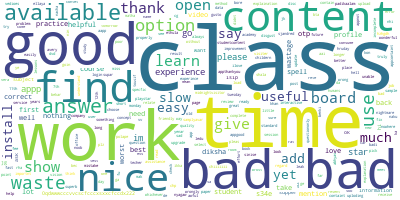

In [107]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(r1_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [136]:
#keyword_freq_per_cluster(r1_elem,2).to_dict()

In [109]:
import re
r1_most_frequent = [y for y in r1_elem if re.search('question', y)]


In [110]:
c1_elem = elem_rate1['c']


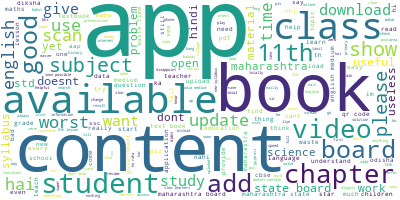

In [111]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(c1_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [137]:
#keyword_freq_per_cluster(c1_elem,3).to_dict()

In [113]:
import re
c1_most_frequent = [y for y in c1_elem if re.search('bad app', y)]


In [114]:
# m1_elem = elem_rate1['m']
# m1_elem

In [115]:
# from wordcloud import WordCloud

# #text = list(eng_df['Review Text'])
# long_string = ','.join(m1_elem)
# wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# wordcloud.generate(long_string)
# wordcloud.to_image()

In [116]:
# keyword_freq_per_cluster(m1_elem,4).to_dict()

In [117]:
# import re
# m1_most_frequent = [y for y in m1_elem if re.search('content', y)]
# m1_most_frequent


# cluster element extraction for each rating


In [138]:
#clustering_rating_wise(initial_df, 1)


# LDA - Topic Modelling for each rating


In [139]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [140]:
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    defaultPos = nltk.pos_tag(token_words) # get the POS tags from NLTK default tagger
    words_lemma = []
    
    #mapping to wordnet lemmatazer
    pos_to_wn = {"JJ": 'a',
             "JJR": 'a',
             "JJS": 'a',
             "NN": 'n', 
             "NNS": 'n', 
             "NNP": 'n', 
             "NNPS": 'n', 
             "VB": 'v',
             "VBD": 'v',
             "VBG": 'v',
             "VBN": 'v',
             "VBP": 'v',
             "VBZ": 'v',
             "RB": 'r',
            "RBR": 'r',
            "RBS": 'r'}
    for item in defaultPos:
        try:
            words_lemma.append(wordnet_lemmatizer.lemmatize(item[0],pos_to_wn[item[1]]))
        except:
            words_lemma.append(item[0])
        #words_lemma.append(lemmatizer.lemmatize(item[0],pos_to_wn(item[1])))
    return " ".join(words_lemma)
#stemSentence(text[0])

In [141]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()


In [142]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [143]:
def LDA_Topic_Modeling_Plotting(text):
    count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 3))
    count_data = count_vectorizer.fit_transform(text)
    plot_10_most_common_words(count_data, count_vectorizer)

    # Tweak the two parameters below
    number_topics = 4
    number_words = 8

    # Create and fit the LDA model
    lda = LDA(n_components=number_topics, n_jobs=-1)
    lda.fit(count_data)

    print("Topics found via LDA:")
    print_topics(lda, count_vectorizer, number_words)

In [ ]:
rating1_text = list(initial_df[initial_df['Star Rating']==1]['Review Text'])
LDA_Topic_Modeling_Plotting(rating1_text)

In [ ]:
rating2_text = list(initial_df[initial_df['Star Rating']==2]['Review Text'])
LDA_Topic_Modeling_Plotting(rating2_text)

In [ ]:
rating3_text = list(initial_df[initial_df['Star Rating']==3]['Review Text'])
LDA_Topic_Modeling_Plotting(rating3_text)

In [ ]:
rating4_text = list(initial_df[initial_df['Star Rating']==4]['Review Text'])
LDA_Topic_Modeling_Plotting(rating4_text)

In [ ]:
rating5_text = list(initial_df[initial_df['Star Rating']==5]['Review Text'])
LDA_Topic_Modeling_Plotting(rating5_text)

In [ ]:
def clustering_rating_upto_3(key_rate_df):
    key_data = key_rate_df.loc[key_rate_df['Star Rating'] <= 3]
    key_rate_df1 = pd.DataFrame(key_data)
#     return key_rate_df1
    ky_ls =key_rate_df1['Review Text'].tolist()
    
    frame = vectorization_of_list(ky_ls)
    frame.set_index(key_rate_df1["Review Text"], inplace = True) 
    return cluster_element_extraction(frame)

In [ ]:
cluster_upto_rate3 = clustering_rating_upto_3(initial_df)

In [ ]:
cluster_upto_rate3

In [ ]:
def clustering_rating_greater_than_3(key_rate_df):
    key_data = key_rate_df.loc[key_rate_df['Star Rating'] > 3]
    key_rate_df1 = pd.DataFrame(key_data)
#     return key_rate_df1
    ky_ls =key_rate_df1['Review Text'].tolist()
    
    frame = vectorization_of_list(ky_ls)
    frame.set_index(key_rate_df1["Review Text"], inplace = True) 
    return cluster_element_extraction(frame)

In [ ]:
cluster_greater_than_rate3 = clustering_rating_greater_than_3(initial_df)

In [ ]:
cluster_greater_than_rate3